In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from scipy.stats import skew
from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split


from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 



In [2]:
def knn_impute(df, missing_val_indicator=999, int_col_index:list=[]):
    
    missing_vals = np.sum(df == missing_val_indicator)
    missing_cols_valuecounts = missing_vals[missing_vals > 0]
    impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
    imputed_arr = impute_knn.fit_transform(df.drop(columns=['ID']))
    
    for idx in int_col_index:
        imputed_arr[:, idx] = np.rint(imputed_arr[:, idx])

    imputed_df = pd.DataFrame.from_records(imputed_arr, columns=df.columns[1:])
    
    return imputed_df

def get_cat_to_one_hot(df, multi_cat_cols):
    df = pd.get_dummies(df, columns=multi_cat_cols)
    
    multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']
    
    for column in multi_category_variables:
        df[column] = df[column].astype(np.float32)
        
    return df
    

In [66]:
def run_RF(X, Y):
    trainX, testX, trainY, testY = train_test_split(X,Y, test_size=0.20)
    regressor = RandomForestRegressor()
    regressor.fit(trainX, trainY.ravel())

    predicted = regressor.predict(testX)
    test_mse_error = mean_squared_error(testY, predicted,)
    test_mae_error = mean_absolute_error(testY, predicted)
    test_r2_error = r2_score(testY, predicted)
    print('TEST METRICS')
    print(f'MSE error: {test_mse_error}')
    print(f'MAE error: {test_mae_error}')
    print(f'R2 error: {test_r2_error}')
    print()
    predicted = regressor.predict(trainX)
    test_mse_error = mean_squared_error(trainY, predicted,)
    test_mae_error = mean_absolute_error(trainY, predicted)
    test_r2_error = r2_score(trainY, predicted)
    print('TRAIN METRICS')
    print(f'MSE error: {test_mse_error}')
    print(f'MAE error: {test_mae_error}')
    print(f'R2 error: {test_r2_error}')
    

# Data Processing

In [12]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)

In [13]:
int_col_mask = og_df.drop(columns=['ID']).dtypes == 'int64'
categorical_features = list(og_df.drop(columns=['ID']).columns[int_col_mask])

# Ignoring 'original_shape_VoxelVolume' because even though it is a int column it is not a categorical feature

categorical_features.remove('original_shape_VoxelVolume')

int_col_index = [i for i, x in enumerate(np.array(int_col_mask)) if x]


In [14]:
imputed_df = knn_impute(og_df, int_col_index = int_col_index)

In [15]:
multiclass_categorical_features = []
others = []

for cat_col_name in categorical_features:
    temp_len = len(imputed_df[cat_col_name].value_counts())
    if temp_len > 2:
        multiclass_categorical_features.append(cat_col_name)
    else:
        others.append(temp_len)

In [19]:

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = categorical_features + multi_category_variables
temp_categorical_features_labels = categorical_features_labels

# Removing multiclass_categorical_features because these features are 
# converted to one-hot encoding

for col_name in multiclass_categorical_features:
    temp_categorical_features_labels.remove(col_name)

temp_categorical_features_labels.remove('pcr')



In [16]:
imputed_df = get_cat_to_one_hot(imputed_df, multi_cat_cols=multiclass_categorical_features)

In [17]:
imputed_df.head()

,pcr,rfs,Age,ER,PgR,HER2,TrippleNegative,HistologyType,LNStatus,original_shape_Elongation,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,0.0,1.0,1.0,1.0,0.813912,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,0.0,0.0,1.0,1.0,0.666118,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,1.0,1.0,0.0,0.645083,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,0.0,1.0,1.0,1.0,0.770842,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.0,1.0,0.0,0.861035,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [150]:
imputed_df.columns

Index(['pcr', 'rfs', 'Age', 'ER', 'PgR', 'HER2', 'TrippleNegative',
       'HistologyType', 'LNStatus', 'original_shape_Elongation',
       ...
       'ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0',
       'Proliferation_1.0', 'Proliferation_2.0', 'Proliferation_3.0',
       'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0',
       'TumourStage_4.0'],
      dtype='object', length=126)

In [18]:
nan_cols = imputed_df.columns[imputed_df.isnull().sum() > 0]

print(f'NaN Columns : {nan_cols}')
if len(nan_cols) > 0:
    imputed_df.drop(columns=nan_cols, inplace=True)

NaN Columns : Index([], dtype='object')


# Dropping Highly correlated features

In [151]:
# Taking values above the diagonal getting the values only from it and making the other elements to NaN.
corr = imputed_df.drop(columns=['pcr', 'rfs']).corr() 
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

#Then taking values (absolute) of the each element and choosing the column to drop by various correlation threshold vales
to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop_90 = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop_85 = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop_80 = [column for column in upper.columns if any(upper[column] > 0.80)]

print(f'Thresholding 95% correlated drop columns : {len(to_drop_95)}')
print(f'Thresholding 90% correlated drop columns : {len(to_drop_90)}')
print(f'Thresholding 85% correlated drop columns : {len(to_drop_85)}')
print(f'Thresholding 80% correlated drop columns : {len(to_drop_80)}')

Thresholding 95% correlated drop columns : 47
Thresholding 90% correlated drop columns : 63
Thresholding 85% correlated drop columns : 75
Thresholding 80% correlated drop columns : 83


In [152]:
imputed_df_corr_removed = imputed_df.drop(to_drop_80, axis=1)

In [44]:
# columns_drop_path = 'dataset/dataset_v1/columns_dropped.pkl'

# with open(columns_drop_path, 'rb') as f:
#     to_drop_90 = pickle.load(f)
    
# imputed_df_corr_removed = imputed_df.drop(to_drop_90, axis=1)

# The variable needs to be used is "imputed_df_corr_removed"

# Univariate Feature Selection:

Use statistical tests to select features based on their individual performance. For example, you can use the chi-squared test for categorical features or the f_regression for numerical features.

In [48]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression


In [75]:
fs_df_X = imputed_df_corr_removed.drop(columns=['pcr', 'rfs'])
fs_df_Y = imputed_df_corr_removed['rfs']

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = fs_df_X.drop(columns=categorical_features_labels).columns

fs_df_X_continous_feature_array = fs_df_X[continous_features_labels].to_numpy()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


fs_df_X_cont_X = scalerTrainX.fit_transform(fs_df_X_continous_feature_array)
fs_df_X_cat_X = fs_df_X[categorical_features_labels].to_numpy()

fs_df_X_arr = np.hstack((fs_df_X_cat_X, fs_df_X_cont_X))              
fs_df_Y_arr = scalerTrainY.fit_transform(fs_df_Y.to_numpy().reshape(-1, 1))



In [89]:
# Example: Univariate feature selection

selector = SelectKBest(f_regression, k=2)  # Choose an appropriate score function


In [90]:
X_new = selector.fit_transform(fs_df_X_arr, fs_df_Y_arr.ravel())

In [91]:
X_new.shape, fs_df_Y_arr.shape

((400, 2), (400, 1))

In [92]:
run_RF(X_new, fs_df_Y_arr)

TEST METRICS
MSE error: 0.05596681730289196
MAE error: 0.18602047164213537
R2 error: -0.21169070095033837

TRAIN METRICS
MSE error: 0.006025402787932931
MAE error: 0.06242717375544708
R2 error: 0.8143132703694194


# Recursive Feature Elimination

In [93]:
from sklearn.feature_selection import RFE

In [94]:
fs_df_X = imputed_df_corr_removed.drop(columns=['pcr', 'rfs'])
fs_df_Y = imputed_df_corr_removed['rfs']

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = fs_df_X.drop(columns=categorical_features_labels).columns

fs_df_X_continous_feature_array = fs_df_X[continous_features_labels].to_numpy()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


fs_df_X_cont_X = scalerTrainX.fit_transform(fs_df_X_continous_feature_array)
fs_df_X_cat_X = fs_df_X[categorical_features_labels].to_numpy()

fs_df_X_arr = np.hstack((fs_df_X_cat_X, fs_df_X_cont_X))              
fs_df_Y_arr = scalerTrainY.fit_transform(fs_df_Y.to_numpy().reshape(-1, 1))



In [130]:
from sklearn import tree
dt_model = tree.DecisionTreeRegressor()
# clf = clf.fit(X, Y)

In [131]:
selector = RFE(dt_model, n_features_to_select=3)
X_new = selector.fit_transform(fs_df_X_arr, fs_df_Y_arr)


In [132]:
X_new.shape

(400, 3)

In [133]:
run_RF(X_new, fs_df_Y_arr)

TEST METRICS
MSE error: 0.03840955289469371
MAE error: 0.15791399016082464
R2 error: -0.16988547668026288

TRAIN METRICS
MSE error: 0.005320659252841269
MAE error: 0.05684872323496527
R2 error: 0.8515941059548732


In [134]:
trainX, testX, trainY, testY = train_test_split(X_new,fs_df_Y_arr, test_size=0.20)

In [143]:
dt_model = tree.DecisionTreeRegressor(min_samples_leaf=5)
dt_model = dt_model.fit(trainX, trainY)

In [144]:
test_predicted = dt_model.predict(testX)
test_mse_error = mean_squared_error(testY, test_predicted,)
test_mae_error = mean_absolute_error(testY, test_predicted)
test_r2_error = r2_score(testY, test_predicted)
print('TEST METRICS')
print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
train_predicted = dt_model.predict(trainX)
test_mse_error = mean_squared_error(trainY, train_predicted,)
test_mae_error = mean_absolute_error(trainY, train_predicted)
test_r2_error = r2_score(trainY, train_predicted)
print('TRAIN METRICS')
print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

TEST METRICS
MSE error: 0.05316823815281141
MAE error: 0.17946403884611337
R2 error: -0.4412565264160613

TRAIN METRICS
MSE error: 0.01748577104801634
MAE error: 0.10147858078666672
R2 error: 0.5011116677357783


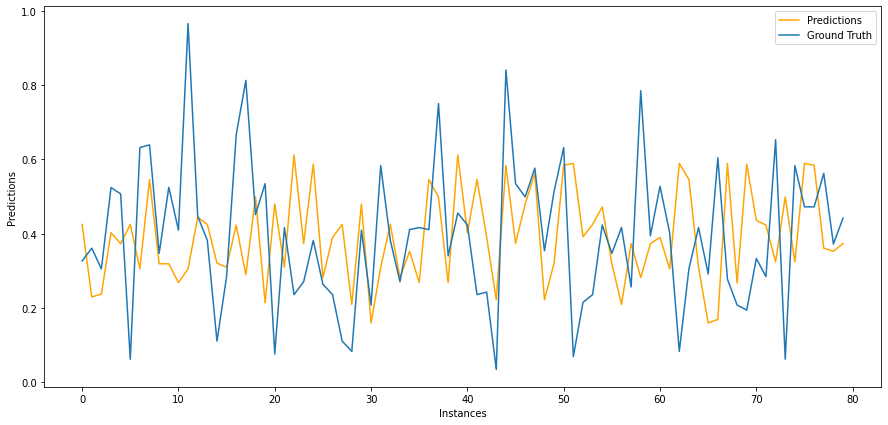

In [145]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(test_predicted))), test_predicted, color='orange', label='Predictions')
plt.plot(list(range(len(test_predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

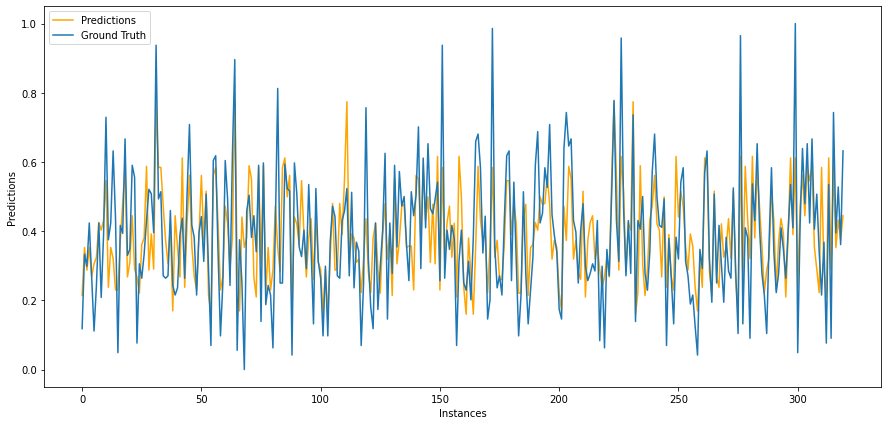

In [146]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(train_predicted))), train_predicted, color='orange', label='Predictions')
plt.plot(list(range(len(train_predicted))), trainY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Training Procedure

In [ ]:
continous_features_labels = imputed_df_corr_removed.drop(columns=temp_categorical_features_labels+['pcr', 'rfs']).columns

In [153]:
imputed_df_corr_removed.columns

Index(['pcr', 'rfs', 'Age', 'ER', 'PgR', 'HER2', 'TrippleNegative',
       'HistologyType', 'LNStatus', 'original_shape_Elongation',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_MeshVolume', 'original_shape_Sphericity',
       'original_shape_SurfaceVolumeRatio', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Minimum',
       'original_firstorder_Skewness', 'original_glcm_Autocorrelation',
       'original_glcm_Correlation', 'original_glcm_Imc1',
       'original_gldm_DependenceEntropy',
       'original_gldm_SmallDependenceEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_glszm_LargeAreaEmphasis',
       '

In [154]:
imputed_df_corr_removed.head()

,pcr,rfs,Age,ER,PgR,HER2,TrippleNegative,HistologyType,LNStatus,original_shape_Elongation,...,original_ngtdm_Busyness,original_ngtdm_Strength,ChemoGrade_1.0,ChemoGrade_2.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,0.0,1.0,1.0,1.0,0.813912,...,473.464852,0.000758,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,0.0,0.0,1.0,1.0,0.666118,...,59.459710,0.003685,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,1.0,1.0,0.0,0.645083,...,33.935384,0.006447,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,0.0,1.0,1.0,1.0,0.770842,...,46.859265,0.004543,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.0,1.0,0.0,0.861035,...,39.621023,0.005626,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [161]:
imputed_df_corr_removed['pcr'].value_counts().index

Index([0.0, 1.0], dtype='float64', name='pcr')

In [164]:
for col in imputed_df_corr_removed.drop(columns=['pcr', 'rfs']).columns:
    if len(imputed_df_corr_removed[col].value_counts().index) < 4:
        print(col)
        

ER
PgR
HER2
TrippleNegative
HistologyType
LNStatus
ChemoGrade_1.0
ChemoGrade_2.0
Proliferation_2.0
Proliferation_3.0
TumourStage_1.0
TumourStage_2.0
TumourStage_3.0
TumourStage_4.0


In [ ]:
hand_categorical_column = ['ER', 'PgR', 'HER2', 'TrippleNegative',
                           'HistologyType', 'LNStatus', 'ChemoGrade_1.0', 'ChemoGrade_2.0',
                           'Proliferation_2.0', 'Proliferation_3.0', 'TumourStage_1.0',
                           'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

In [20]:
continous_feature_array = imputed_df[continous_features_labels].to_numpy()


# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()
# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


cont_X = scalerTrainX.fit_transform(continous_feature_array)
cat_X = imputed_df[temp_categorical_features_labels].to_numpy()
X = np.hstack((cat_X, cont_X))
                   
Y = scalerTrainY.fit_transform(imputed_df['rfs'].to_numpy().reshape(-1, 1))
# trainY = train['rfs'].to_numpy().reshape(-1, 1)
                 

In [36]:
tsne = TSNE(n_components=7, verbose=1, perplexity=40, n_iter=1000, method='exact')
tsne_results = tsne.fit_transform(X)

C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.059909
[t-SNE] KL divergence after 250 iterations with early exaggeration: 148.788153
[t-SNE] KL divergence after 1000 iterations: 4.276737


In [25]:
tsne_results.shape

(400, 10)

In [27]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


In [166]:
trainX, testX, trainY, testY = train_test_split(X,Y, test_size=0.20)

In [167]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((320, 124), (80, 124), (320, 1), (80, 1))

In [168]:
regressor = RandomForestRegressor()
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor()

In [181]:
regressor = RandomForestRegressor()
regressor.fit(np.exp(trainX), trainY.ravel())

RandomForestRegressor()

In [182]:
predicted = regressor.predict(np.exp(testX))
test_mse_error = mean_squared_error(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.03938413625679897
MAE error: 0.15859939236056422
R2 error: 0.026700059992203484


In [184]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'Test MSE error: {test_mse_error}')
print(f'Test MAE error: {test_mae_error}')
print(f'Test R2 error: {test_r2_error}')

Test MSE error: 0.04920836117987401
Test MAE error: 0.17939771411930555
Test R2 error: -0.21608595582657286


In [185]:
predicted = regressor.predict(np.exp(trainX))
test_mse_error = mean_squared_error(trainY, predicted,)
test_mae_error = mean_absolute_error(trainY, predicted)
test_r2_error = r2_score(trainY, predicted)

print(f'Train MSE error: {test_mse_error}')
print(f'Train MAE error: {test_mae_error}')
print(f'Train R2 error: {test_r2_error}')

Train MSE error: 0.004372024855219939
Train MAE error: 0.0513849645543533
Train R2 error: 0.8716979309353514


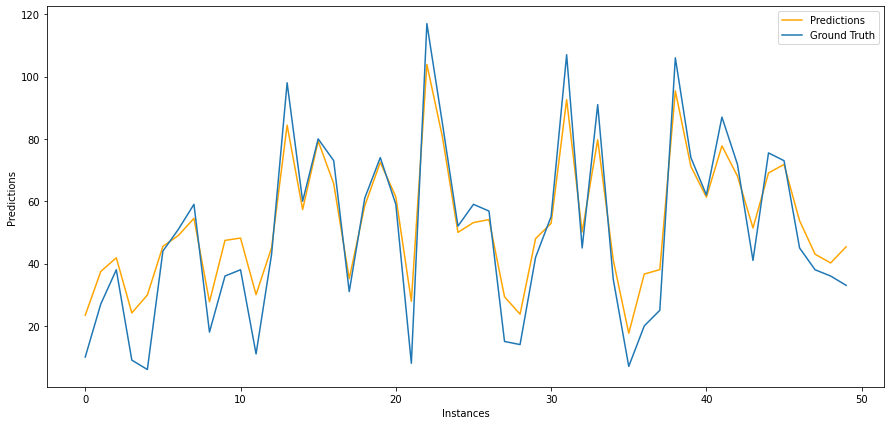

In [173]:

plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted[:50]))), scalerTrainY.inverse_transform(predicted[:50].reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted[:50]))),scalerTrainY.inverse_transform(trainY[:50].reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# To check for multicollinearity and then remove features that are less correlated with the target column, we followed these steps:

Compute the correlation matrix for all features.
Identify pairs of highly correlated features (e.g., correlation greater than a certain threshold, like 0.8).
Compare the correlation of each feature in the pair with the target variable.
Remove the feature from each pair that has a lower correlation with the target variable.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data
# data = pd.read_csv('your_dataset.csv')

# Assuming 'data' is your DataFrame and 'target' is your target variable name
target = 'YourTargetColumnName'

# Step 1: Compute the correlation matrix
correlation_matrix = data.corr()

# Step 2: Identify pairs of highly correlated features
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.append((correlation_matrix.columns[j], colname))

# Step 3 and 4: Remove the feature from each pair with lower correlation with the target
features_to_remove = set()
for pair in high_corr_pairs:
    if abs(data[pair[0]].corr(data[target])) > abs(data[pair[1]].corr(data[target])):
        features_to_remove.add(pair[1])
    else:
        features_to_remove.add(pair[0])

# Creating a new dataset with reduced features
data_reduced = data.drop(columns=features_to_remove)

# Now you can proceed with splitting the data and applying your model
# X = data_reduced.drop(columns=[target])
# y = data_reduced[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ... Continue with your model training and evaluation
